# Calculate Price Elasticity Scores: Hex x Timebucket

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

import ast
import datetime
import glob
import json
import uuid
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
tqdm.pandas()

from h3 import h3
from sklearn.linear_model import LinearRegression

In [2]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

In [3]:
CONFIG_CITY = 'Hyderabad'
CONFIG_SERVICE_LEVEL = 'Link'
CONFIG_EXPERIMENT_DATE = datetime.date(2022, 12, 11)
OUTPUT_DIRECTORY = '/tmp/price_elasticity/'

In [4]:
from pyhive import presto
presto_connection = presto.connect(
    host='bi-presto.serving.data.production.internal',
    port='80',
    username='bhargav.k@rapido.bike'
)

In [5]:
query = """
SELECT
    icr.yyyymmdd,
    CASE
        WHEN icr.quarter_hour >= '0000' AND icr.quarter_hour < '0800' THEN 'rest_morning'
        WHEN icr.quarter_hour >= '0800' AND icr.quarter_hour < '1200' THEN 'morning_peak'
        WHEN icr.quarter_hour >= '1200' AND icr.quarter_hour < '1700' THEN 'afternoon'
        WHEN icr.quarter_hour >= '1700' AND icr.quarter_hour < '2200' THEN 'evening_peak'
        WHEN icr.quarter_hour >= '2200' AND icr.quarter_hour < '2400' THEN 'rest_evening'
    END timebucket,
    icr.hour,
    icr.quarter_hour,
    icr.city,
    icr.computed_pickup_cluster cluster,
    icr.computed_pick_hex8 hex,
    icr.fare_estimate_id,
    icr.customer_id,
    icr.dynamic_surge_factor_type surge_type,
    icr.dynamic_surge_factor surge_percentage,  -- For the price elasticity experiments, surge is as a percentage.
    icr.dynamic_surge_amount surge_amount,
    icr.rate_card_amount,
    fee.sub_total,
    ols.order_id,
    ols.order_status
FROM
        experiments.iprice_cleaned_responses_v2 icr
        JOIN hive.pricing.fare_estimates_enriched fee ON fee.yyyymmdd = '{yyyymmdd}'
            AND fee.service_name = '{service_level}'
            AND fee.fare_estimate_id = icr.fare_estimate_id
        LEFT JOIN hive.orders.order_logs_snapshot ols ON ols.yyyymmdd = '{yyyymmdd}'
            AND ols.estimate_id = icr.fare_estimate_id
            AND ols.service_obj_service_name = '{service_level}'
WHERE
        icr.yyyymmdd = '{yyyymmdd}'
        AND icr.city = '{city}'
        AND icr.service_level = '{service_level}'
        AND icr.surge_strategy = 'experiment'
""".format(
    yyyymmdd = CONFIG_EXPERIMENT_DATE.strftime('%Y%m%d'),
    service_level = CONFIG_SERVICE_LEVEL,
    city = CONFIG_CITY,
)
fare_estimates_raw = pd.read_sql_query(query, presto_connection)

In [6]:
fare_estimates = fare_estimates_raw.copy(deep=True)

# Convert columns from string to float.
columns = ['surge_percentage', 'surge_amount', 'rate_card_amount']
fare_estimates[columns] = fare_estimates[columns].astype('float')

def calculate_is_dropped_order(row):
    if row['order_status'] == 'dropped':
        return row['order_id']
fare_estimates['dropped_order_id'] = fare_estimates.apply(calculate_is_dropped_order, axis=1)

# Replace dynamic surge factor in the Control group.
fare_estimates['surge_percentage'].replace(-999, 0.0, inplace=True)

print(fare_estimates.shape)
fare_estimates.head(1)

(1401045, 17)


,yyyymmdd,timebucket,hour,quarter_hour,city,cluster,hex,fare_estimate_id,customer_id,surge_type,surge_percentage,surge_amount,rate_card_amount,sub_total,order_id,order_status,dropped_order_id
0,20221211,morning_peak,8,0830,Hyderabad,kistareddypet,8860a24965fffff,63954894110805811776898d,6395477fbd2a2364d479f5d3,percentage,40.0,156.16,390.4,550.0,None,None,None


In [7]:
# Validate the experiment setup by aggregating fare estimates by surge percentage.
counts = fare_estimates \
    .groupby('surge_percentage') \
    .agg(
        fare_estimates=pd.NamedAgg('fare_estimate_id', 'nunique'),
        gross_orders=pd.NamedAgg('order_id', 'nunique'),
        net_orders=pd.NamedAgg('dropped_order_id', 'nunique'),
    ) \
    .reset_index()

counts['fare_percentage'] = (100 * counts['fare_estimates'] / counts['fare_estimates'].sum()).round()
counts['gross_percentage'] = (100 * counts['gross_orders'] / counts['gross_orders'].sum()).round()
counts['net_percentage'] = (100 * counts['net_orders'] / counts['net_orders'].sum()).round()
counts

,surge_percentage,fare_estimates,gross_orders,net_orders,fare_percentage,gross_percentage,net_percentage
0,0.0,705062,85861,33447,50.0,57.0,57.0
1,10.0,140878,15952,6223,10.0,11.0,11.0
2,20.0,136388,14143,5528,10.0,9.0,9.0
3,30.0,141093,13068,5197,10.0,9.0,9.0
4,40.0,138054,11307,4489,10.0,8.0,8.0
5,50.0,137140,10402,4095,10.0,7.0,7.0


In [8]:
def calculate_price_elasticity(row):

    try:

        delta_fe2rr = (row['fe2rr'] - row['previous_fe2rr']) / ((row['fe2rr'] + row['previous_fe2rr']) / 2)
        delta_surge_percentage = (row['surge_percentage'] - row['previous_surge_percentage']) / ((row['surge_percentage'] + row['previous_surge_percentage']) / 2)

        return round(delta_fe2rr / delta_surge_percentage, 2)
        
    except ZeroDivisionError as e:
        pass

calculate_price_elasticity({'fe2rr': 14, 'previous_fe2rr': 10, 'surge_percentage': 20, 'previous_surge_percentage': 30})

-0.83

In [9]:
def calculate_price_elasticity_label(ep):
    """Calculate the ep label based on the ep value."""

    # Remove the negative sign when present.
    ep = abs(ep)

    if pd.isna(ep):  return 'undefined'
    if ep == 0.0:    return 'perfectly_inelastic'
    elif ep == 1.0:  return 'unitary_elastic'
    elif ep > 1.0:   return 'highly_elastic'
    elif ep < 1.0:   return 'less_elastic'
    else:            return 'error'

calculate_price_elasticity_label(0.8)

'less_elastic'

In [10]:
# Get a sample pickup cluster for looking at examples.
sample = fare_estimates \
    .groupby(['cluster', 'hex', 'timebucket']) \
    .agg(fare_estimates=pd.NamedAgg('fare_estimate_id', 'nunique')) \
    .reset_index() \
    .sort_values(ascending=False, by='fare_estimates').iloc[0]

sample

cluster               Hitech City
hex               8860a259bbfffff
timebucket           evening_peak
fare_estimates               6822
Name: 2029, dtype: object

## Hex x Timebucket

In [11]:
# Aggregate by geo-temporal slice of hex x timebucket.
dataset = fare_estimates \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex', 'surge_percentage']) \
    .agg(
        fare_estimates=pd.NamedAgg('fare_estimate_id', 'nunique'),
        gross_orders=pd.NamedAgg('order_id', 'nunique')
    ) \
    .reset_index()    

dataset['fe2rr'] = (100 * dataset['gross_orders'] / dataset['fare_estimates']).round(2)

print(dataset.shape)
dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
].sort_values(by='surge_percentage')

(23082, 9)


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr
10955,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,0.0,3346,634,18.95
10956,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,10.0,660,136,20.61
10957,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,20.0,708,135,19.07
10958,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,30.0,675,106,15.70
10959,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,40.0,689,76,11.03
10960,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,50.0,744,90,12.10


In [12]:
# Shift surge percentage and FE2RR for a geo-temporal slice.
dataset.sort_values(by=['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex', 'surge_percentage'], inplace=True)
dataset['previous_surge_percentage'] = dataset.groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex'])['surge_percentage'].shift()
dataset['previous_fe2rr'] = dataset.groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex'])['fe2rr'].shift()

print(dataset.shape)
dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
].sort_values(by='surge_percentage')

(23082, 11)


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,previous_surge_percentage,previous_fe2rr
10955,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,0.0,3346,634,18.95,NaN,NaN
10956,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,10.0,660,136,20.61,0.0,18.95
10957,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,20.0,708,135,19.07,10.0,20.61
10958,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,30.0,675,106,15.70,20.0,19.07
10959,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,40.0,689,76,11.03,30.0,15.70
10960,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,50.0,744,90,12.10,40.0,11.03


In [13]:
# Calculate price elasticity and price elasticity labels.
dataset['price_elasticity'] = dataset.apply(calculate_price_elasticity, axis=1)
dataset['price_elasticity_label'] = dataset['price_elasticity'].apply(calculate_price_elasticity_label)

dataset.drop(columns=['previous_surge_percentage', 'previous_fe2rr'], inplace=True)

print(dataset.shape)
dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
].sort_values(by='surge_percentage').reset_index(drop=True)

(23082, 11)


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,price_elasticity,price_elasticity_label
0,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,0.0,3346,634,18.95,NaN,undefined
1,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,10.0,660,136,20.61,0.04,less_elastic
2,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,20.0,708,135,19.07,-0.12,less_elastic
3,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,30.0,675,106,15.70,-0.48,less_elastic
4,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,40.0,689,76,11.03,-1.22,highly_elastic
5,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,50.0,744,90,12.10,0.42,less_elastic


In [14]:
# Distribution of geo-temporal slices by their elasticity labels.
counts = dataset \
    .groupby(['price_elasticity_label']) \
    .agg(fare_estimates=pd.NamedAgg('fare_estimates', 'sum')) \
    .sort_values(by=['fare_estimates'], ascending=False) \
    .reset_index()

counts['fare_percentage'] = (100 * counts['fare_estimates'] / counts['fare_estimates'].sum()).round(1)
counts

,price_elasticity_label,fare_estimates,fare_percentage
0,undefined,726586,52.0
1,less_elastic,352617,25.2
2,highly_elastic,302396,21.6
3,unitary_elastic,12489,0.9
4,perfectly_inelastic,4527,0.3


In [15]:
counts = dataset \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']) \
    .agg({'fare_estimates': 'sum'}) \
    .reset_index() \
    .sort_values(by='fare_estimates', ascending=False) \
    .reset_index(drop=True)

sample = counts.iloc[0]
sample

yyyymmdd                 20221211
timebucket           evening_peak
city                    Hyderabad
cluster               Hitech City
hex               8860a259bbfffff
fare_estimates               6822
Name: 0, dtype: object

In [16]:
# sample = {'cluster': 'Shamshabad 4', 'timebucket': 'evening_peak', 'city': 'Hyderabad'}

In [17]:
columns = ['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex', 'surge_percentage', 'fare_estimates', 'gross_orders', 'fe2rr', 'price_elasticity', 'price_elasticity_label']
dataset_subset = dataset[
    (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
    & (dataset['timebucket'] == sample['timebucket'])
][columns].reset_index(drop=True).copy(deep=True)
dataset_subset

,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,price_elasticity,price_elasticity_label
0,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,0.0,3346,634,18.95,NaN,undefined
1,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,10.0,660,136,20.61,0.04,less_elastic
2,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,20.0,708,135,19.07,-0.12,less_elastic
3,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,30.0,675,106,15.70,-0.48,less_elastic
4,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,40.0,689,76,11.03,-1.22,highly_elastic
5,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,50.0,744,90,12.10,0.42,less_elastic


In [18]:
model = LinearRegression()
model.fit(dataset_subset[['surge_percentage']], dataset_subset['fe2rr'])
slope, intercept = round(model.coef_[0], 3), round(model.intercept_, 3)
slope, intercept

(-0.19, 20.983)

In [19]:
score = round(model.score(dataset_subset[['surge_percentage']], dataset_subset['fe2rr']), 3)
score

0.796

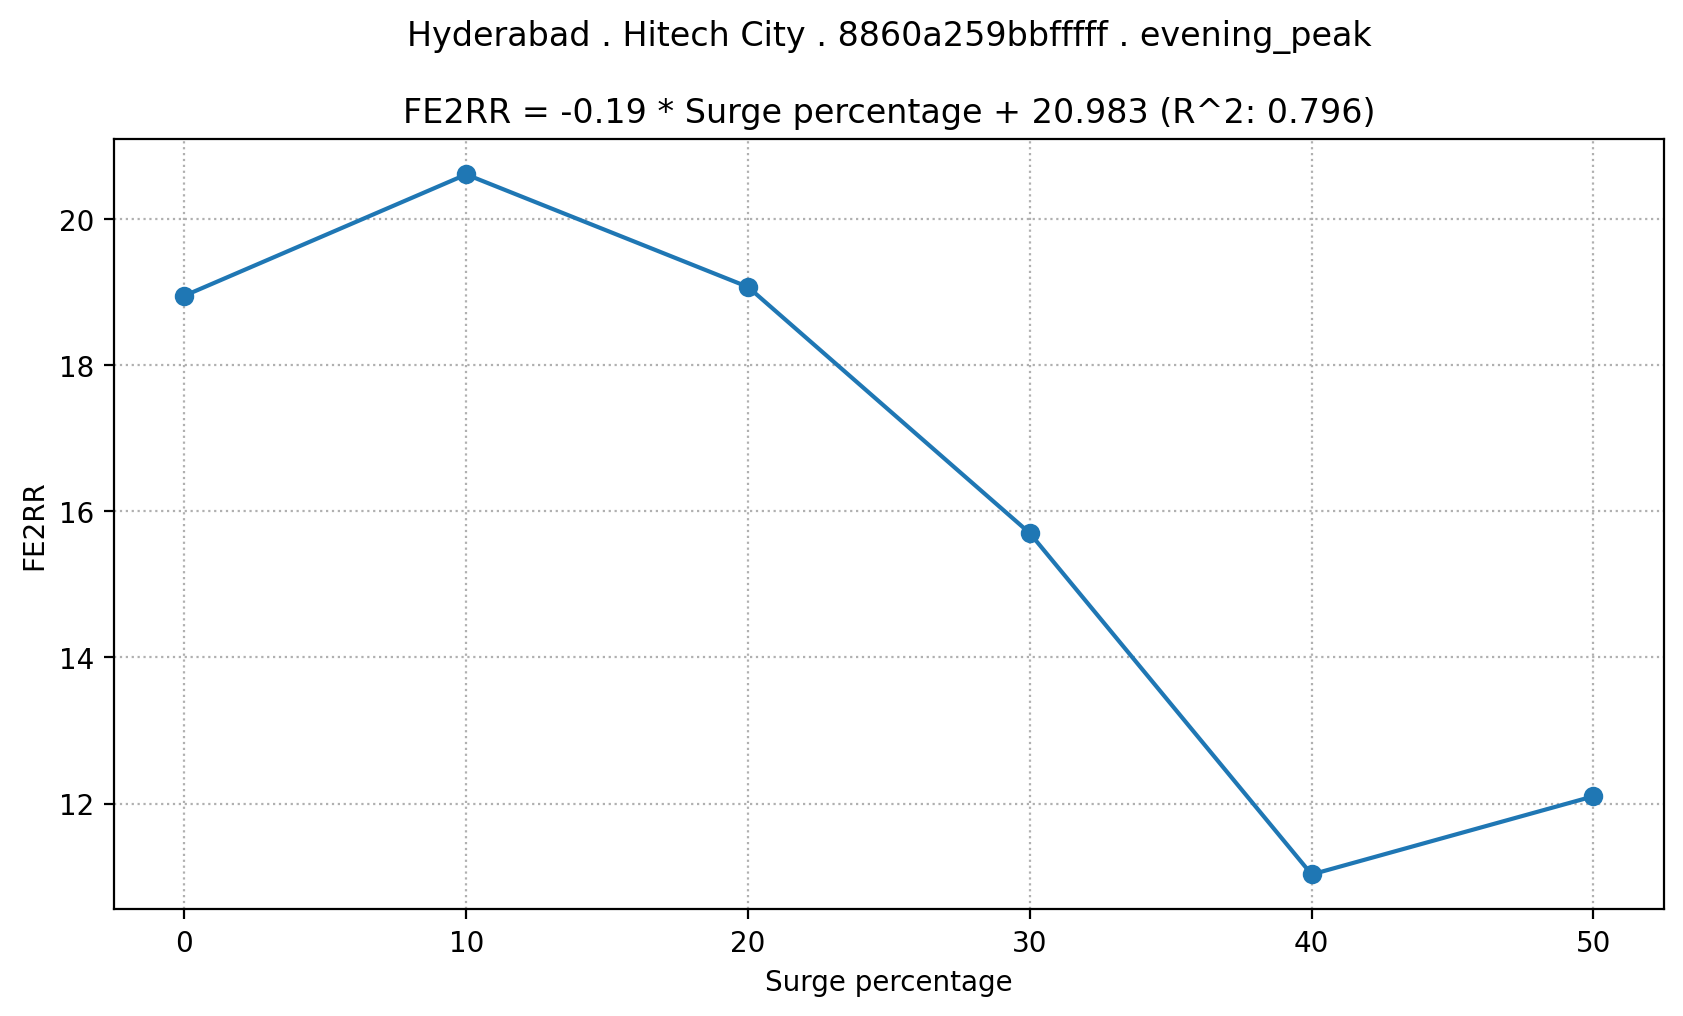

In [20]:
ax = dataset_subset.plot(x='surge_percentage', y='fe2rr', figsize=(10, 5), marker='o')

plt.grid(linestyle='dotted')
ax.legend().remove()
ax.set_xlabel('Surge percentage')
ax.set_ylabel('FE2RR')
ax.set_title('{} . {} . {} . {}\n\nFE2RR = {} * Surge percentage + {} (R^2: {})'.format(
    sample['city'], sample['cluster'], sample['hex'], sample['timebucket'],
    slope, intercept,
    score
));

In [21]:
# Geo-temporal slices that have multiple price elasticity labels.
dataset.groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']).agg({'price_elasticity_label': 'nunique'}).sort_values(ascending=False, by='price_elasticity_label').head(5)

price_elasticity_label
yyyymmdd timebucket   city      cluster      hex                                    
20221211 evening_peak Hyderabad Manikonda    8860a258b5fffff                       5
         afternoon    Hyderabad Nagole       8860b52507fffff                       5
                                Hitech City  8860a259bbfffff                       5
         morning_peak Hyderabad Hayath Nagar 8860b52547fffff                       5
                                Shamshabad   8860a25a09fffff                       5

In [22]:
# What is the volume of fare estimates and gross orders in the geotemporal slices?
dataset[['fare_estimates', 'gross_orders']].describe().round(1)

,fare_estimates,gross_orders
count,23082.0,23082.0
mean,60.6,6.5
std,128.3,17.7
min,1.0,0.0
25%,5.0,0.0
50%,20.0,1.0
75%,62.8,6.0
max,3346.0,634.0


In [23]:
# Calculate one elasticity label for the entire geo-temporal slice.
counts = dataset \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']) \
    .agg({'fare_estimates': 'sum'}) \
    .reset_index() \
    .sort_values(by='fare_estimates', ascending=False) \
    .reset_index(drop=True)

In [24]:
def calculate_geotemporal_price_elasticity(rows):

    old = rows.iloc[0]
    new = rows.iloc[-1]

    try:
        price_delta = (new['surge_percentage'] - old['surge_percentage']) / ((new['surge_percentage'] + old['surge_percentage']) / 2)
        quantity_delta = (new['fe2rr'] - old['fe2rr']) / ((new['fe2rr'] + old['fe2rr']) / 2)

        return round(quantity_delta / price_delta, 2)
    except ZeroDivisionError as e:
        return

In [25]:
dataset_subset = dataset[
    (dataset['yyyymmdd'] == sample['yyyymmdd'])
    & (dataset['timebucket'] == sample['timebucket'])
    & (dataset['city'] == sample['city'])
    & (dataset['cluster'] == sample['cluster'])
    & (dataset['hex'] == sample['hex'])
][columns].reset_index(drop=True).copy(deep=True)

print(calculate_geotemporal_price_elasticity(dataset_subset))

dataset_subset

-0.22


,yyyymmdd,timebucket,city,cluster,hex,surge_percentage,fare_estimates,gross_orders,fe2rr,price_elasticity,price_elasticity_label
0,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,0.0,3346,634,18.95,NaN,undefined
1,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,10.0,660,136,20.61,0.04,less_elastic
2,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,20.0,708,135,19.07,-0.12,less_elastic
3,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,30.0,675,106,15.70,-0.48,less_elastic
4,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,40.0,689,76,11.03,-1.22,highly_elastic
5,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,50.0,744,90,12.10,0.42,less_elastic


In [26]:
results = []
for i, row in counts.drop(columns='fare_estimates').iterrows():

    columns = ['yyyymmdd', 'timebucket', 'city', 'cluster', 'surge_percentage', 'fare_estimates', 'gross_orders', 'fe2rr', 'price_elasticity', 'price_elasticity_label']
    dataset_subset = dataset[
        (dataset['yyyymmdd'] == row['yyyymmdd'])
        & (dataset['timebucket'] == row['timebucket'])
        & (dataset['city'] == row['city'])
        & (dataset['cluster'] == row['cluster'])
        & (dataset['hex'] == row['hex'])
    ][columns].reset_index(drop=True).copy(deep=True).sort_values(by='surge_percentage')

    result = row.to_dict()
    result['price_elasticity'] = calculate_geotemporal_price_elasticity(dataset_subset)
    result['price_elasticity_label'] = calculate_price_elasticity_label(result['price_elasticity'])

    model = LinearRegression()
    model.fit(dataset_subset[['surge_percentage']], dataset_subset['fe2rr'])
    result['price_elasticity_curve_slope'] = round(model.coef_[0], 3)
    result['price_elasticity_curve_intercept'] = round(model.intercept_, 3)

    result['price_elasticity_curve_confidence'] = round(model.score(dataset_subset[['surge_percentage']], dataset_subset['fe2rr']), 3)
    if result['price_elasticity_curve_slope'] == 0 and result['price_elasticity_curve_confidence'] == 0:
        result['price_elasticity_curve_confidence'] = 0
    elif pd.isna(result['price_elasticity_curve_confidence']):
        result['price_elasticity_curve_confidence'] = 0

    result['surge_percentages'] = dataset_subset['surge_percentage'].agg(lambda x: json.dumps(list(x.values)))
    result['fare_estimates'] = dataset_subset['fare_estimates'].agg(lambda x: json.dumps([int(item) for item in list(x.values)]))
    result['gross_orders'] = dataset_subset['gross_orders'].agg(lambda x: json.dumps([int(item) for item in list(x.values)]))
    result['fe2rrs'] = dataset_subset['fe2rr'].agg(lambda x: json.dumps(list(x.values)))
    result['price_elasticities'] = dataset_subset['price_elasticity'].agg(lambda x: json.dumps(list(x.values)))
    result['price_elasticity_labels'] = dataset_subset['price_elasticity_label'].agg(lambda x: json.dumps(list(x.values)))

    results.append(result)

results = pd.DataFrame(results)

print(results.shape)
results.head(1)

(5365, 16)


,yyyymmdd,timebucket,city,cluster,hex,price_elasticity,price_elasticity_label,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence,surge_percentages,fare_estimates,gross_orders,fe2rrs,price_elasticities,price_elasticity_labels
0,20221211,evening_peak,Hyderabad,Hitech City,8860a259bbfffff,-0.22,less_elastic,-0.19,20.983,0.796,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[3346, 660, 708, 675, 689, 744]","[634, 136, 135, 106, 76, 90]","[18.95, 20.61, 19.07, 15.7, 11.03, 12.1]","[NaN, 0.04, -0.12, -0.48, -1.22, 0.42]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."


In [27]:
# What is the distribution of geo-temporal slices by elasticity label.
counts = results['price_elasticity_label'].value_counts().reset_index(name='geotemporal_slices')
counts['geotemporal_percentage'] = (100 * counts['geotemporal_slices'] / counts['geotemporal_slices'].sum()).round(2)
counts.sort_values(by='geotemporal_percentage', ascending=False).reset_index(drop=True)

,index,geotemporal_slices,geotemporal_percentage
0,less_elastic,2045,38.12
1,undefined,1760,32.81
2,unitary_elastic,1496,27.88
3,perfectly_inelastic,37,0.69
4,highly_elastic,27,0.50


In [28]:
results.describe().round(2)

,price_elasticity,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence
count,3605.00,5365.00,5365.00,5365.00
mean,-0.43,-0.07,11.86,0.35
std,0.62,0.52,19.24,0.37
min,-7.00,-12.00,-200.00,0.00
25%,-1.00,-0.16,0.00,0.01
50%,-0.42,-0.02,8.67,0.21
75%,-0.07,0.00,14.46,0.62
max,9.00,10.00,280.00,1.00


In [29]:
results.groupby('timebucket').agg({'price_elasticity': 'median'}).sort_values(by='price_elasticity', ascending=False)

,price_elasticity
timebucket,
rest_morning,0.00
evening_peak,-0.36
afternoon,-0.43
morning_peak,-0.51


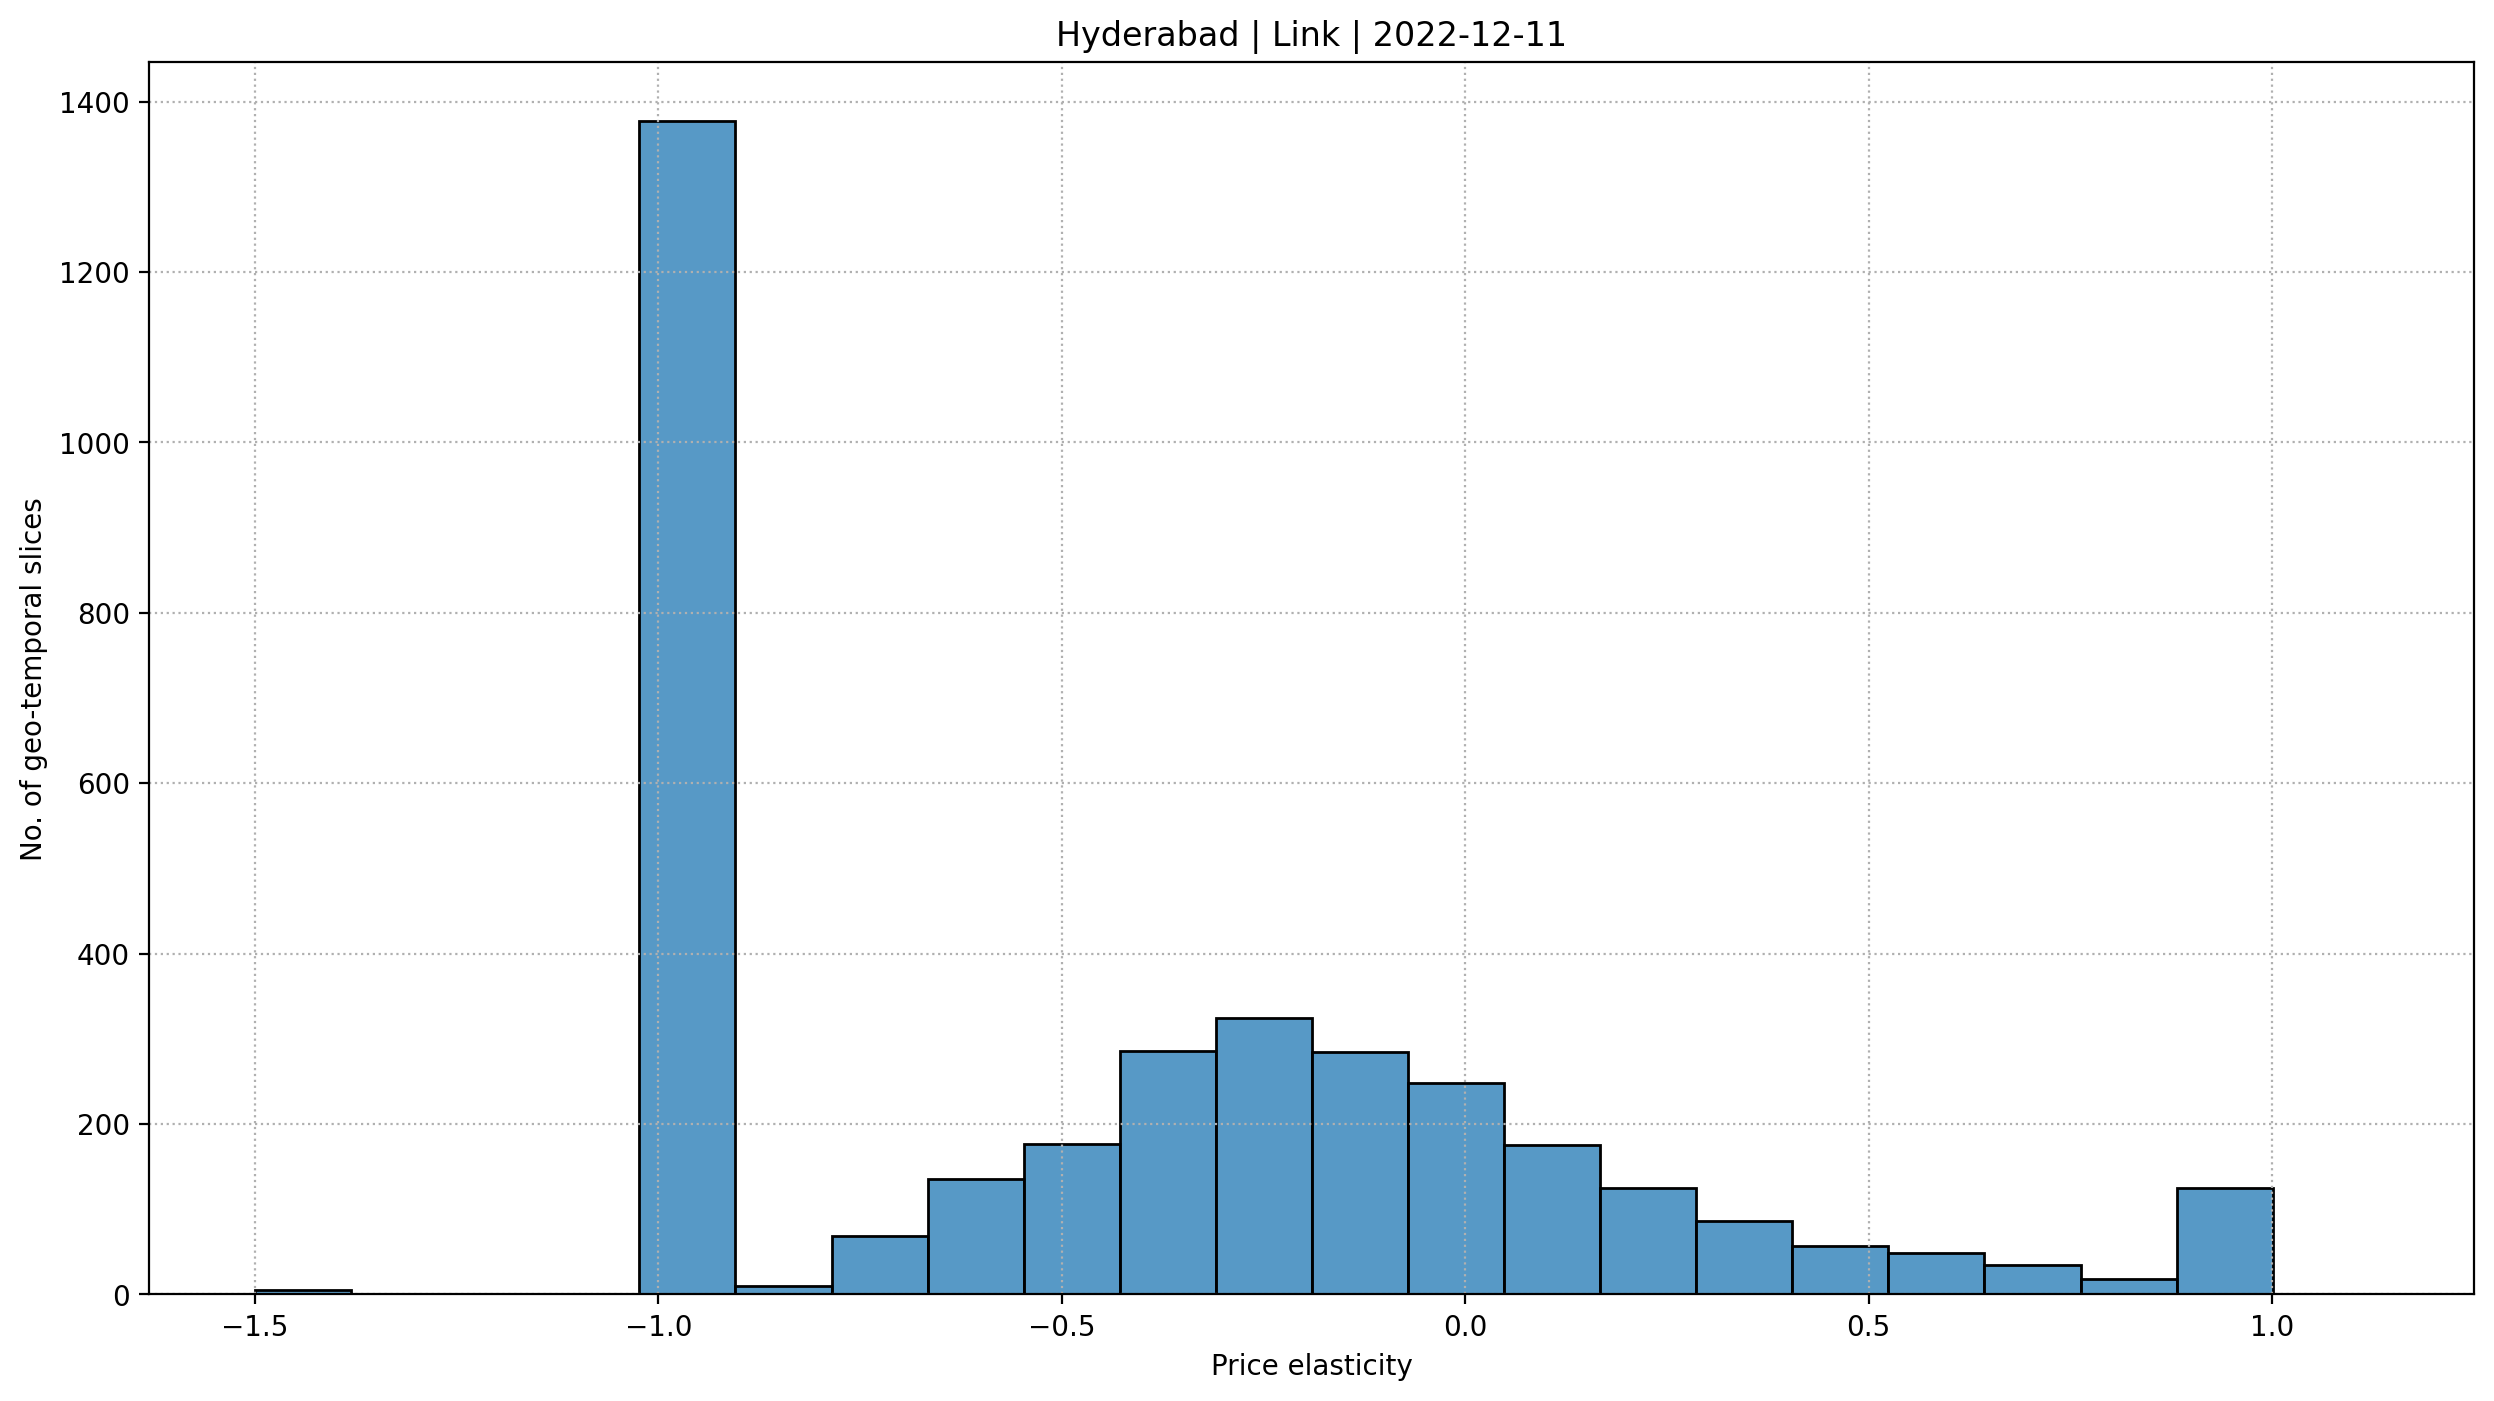

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.histplot(data=results[(results['price_elasticity'] >= -1.5) & (results['price_elasticity'] <= 1.5)], x='price_elasticity', ax=ax)
ax.grid(linestyle='dotted')
ax.set_xlabel('Price elasticity')
ax.set_ylabel('No. of geo-temporal slices')
ax.set_title('{} | {} | {}'.format(CONFIG_CITY, CONFIG_SERVICE_LEVEL, CONFIG_EXPERIMENT_DATE));

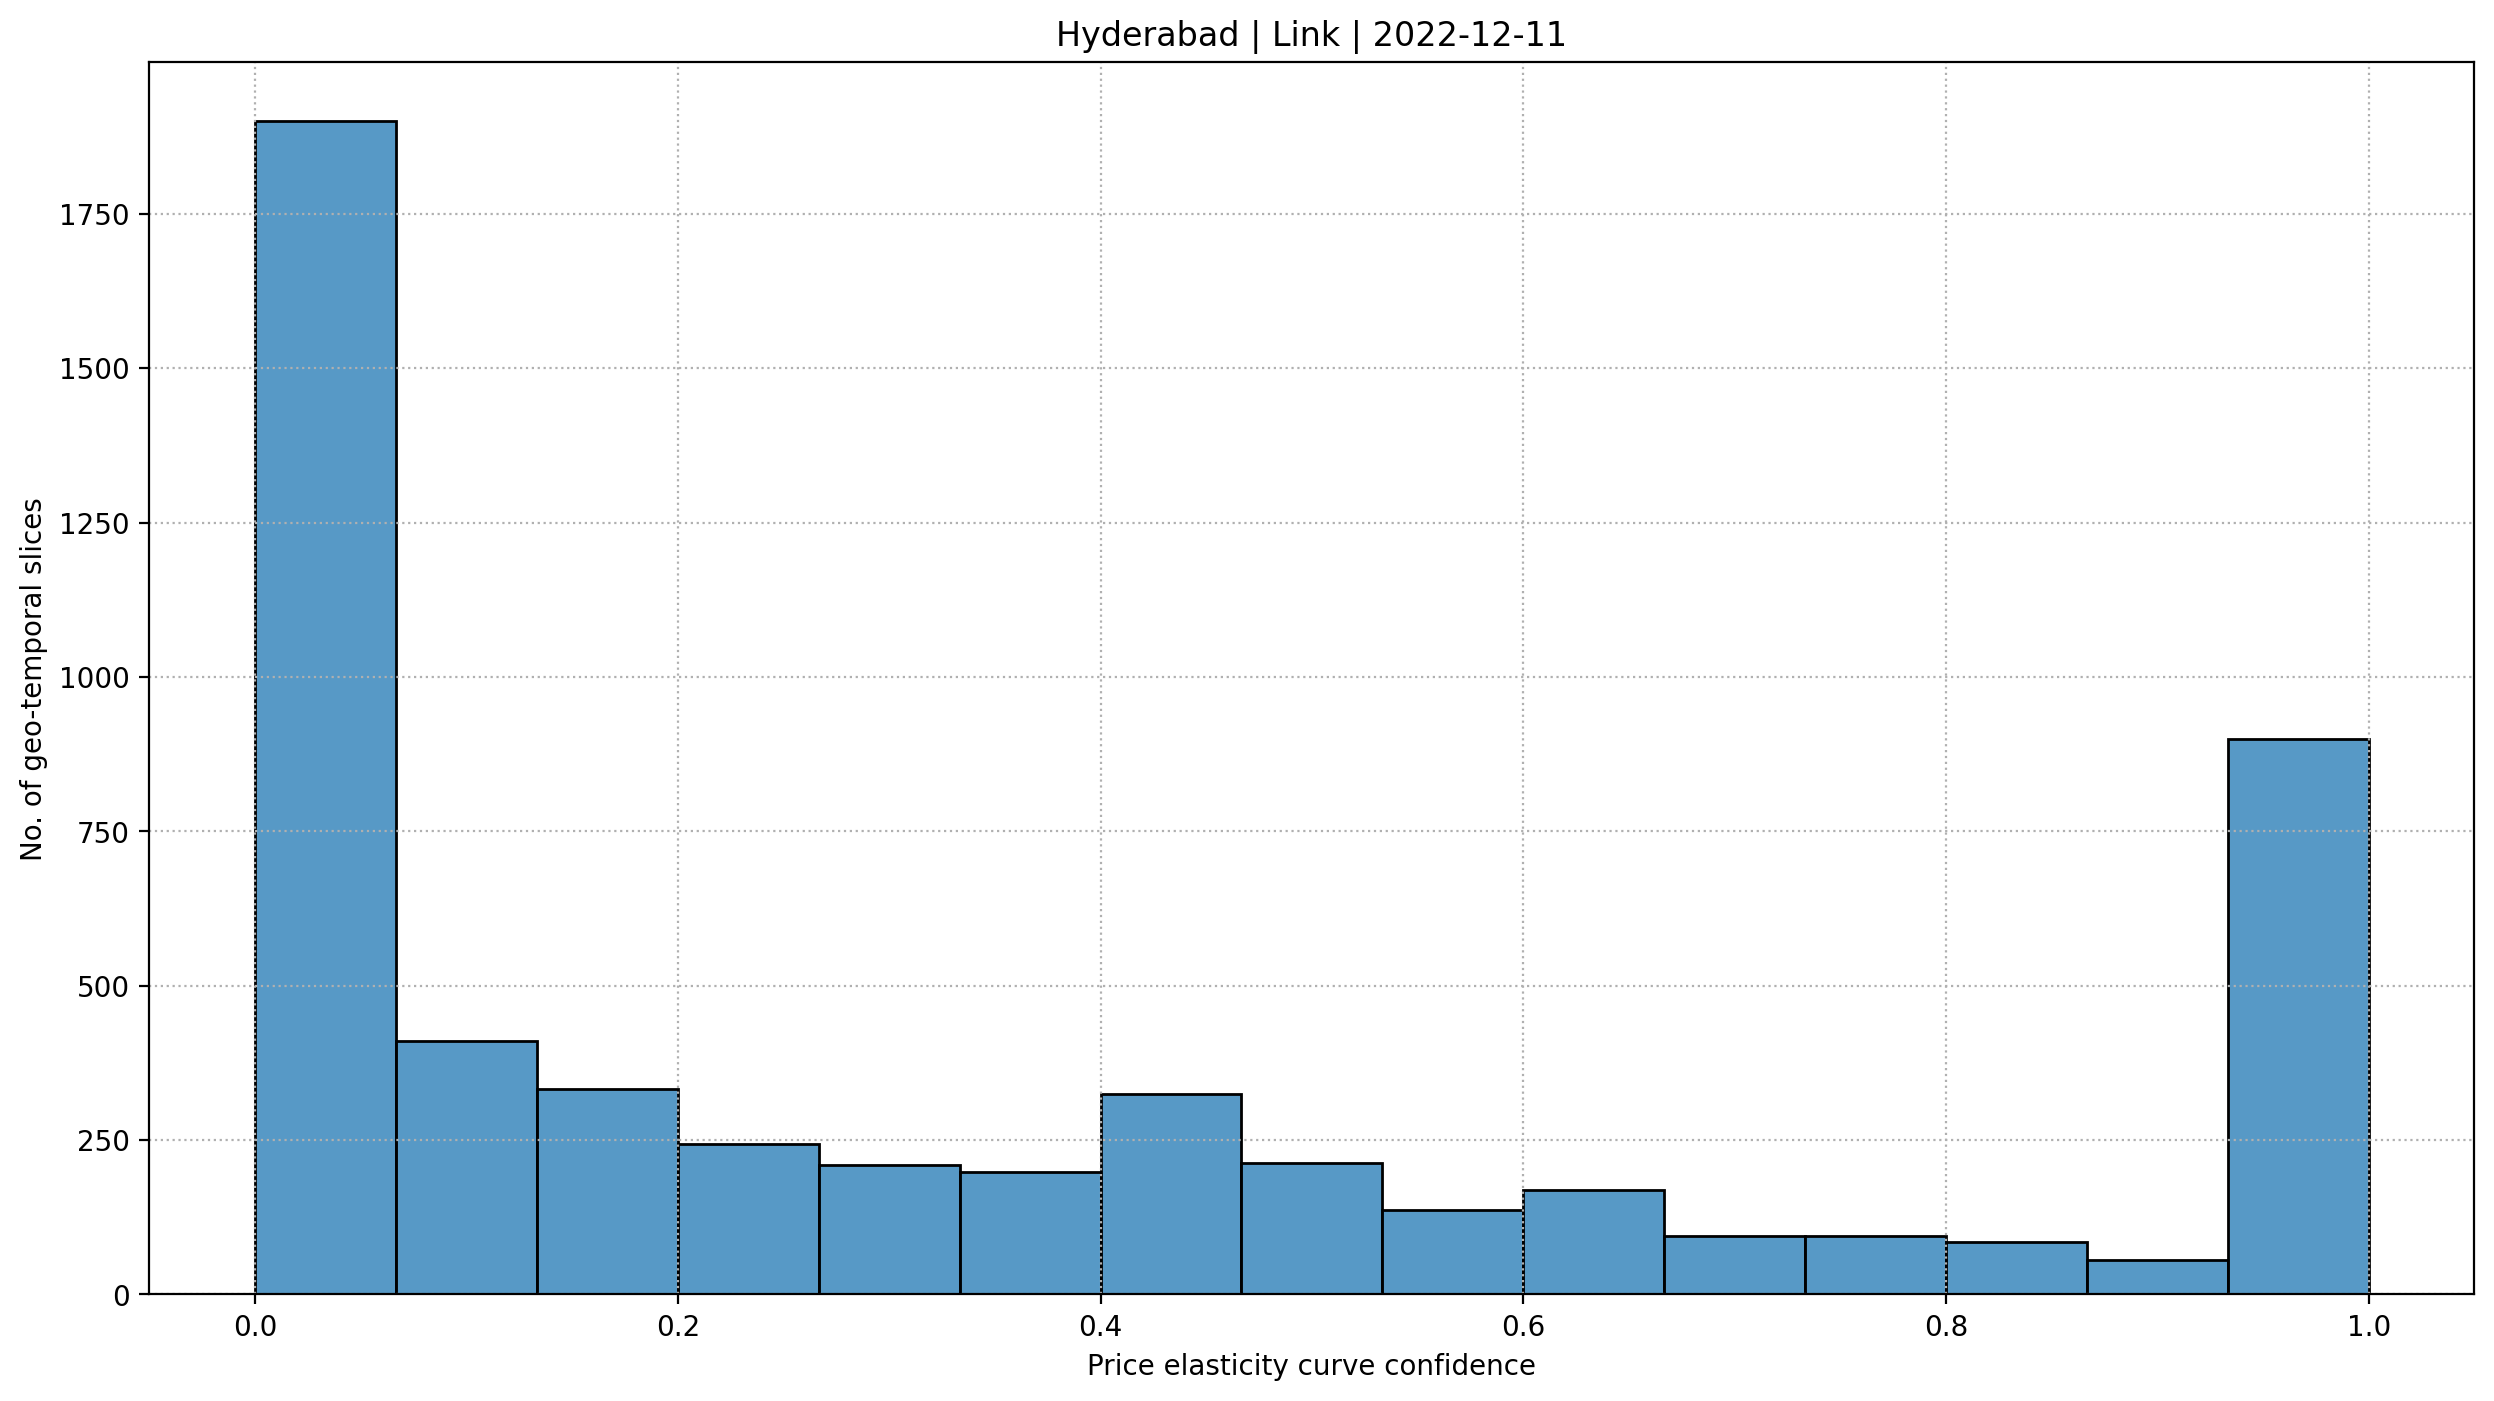

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = sns.histplot(data=results, x='price_elasticity_curve_confidence', ax=ax)
ax.grid(linestyle='dotted')
ax.set_xlabel('Price elasticity curve confidence')
ax.set_ylabel('No. of geo-temporal slices')
ax.set_title('{} | {} | {}'.format(CONFIG_CITY, CONFIG_SERVICE_LEVEL, CONFIG_EXPERIMENT_DATE));

In [32]:
# View elasticities for some sample geo-temporal slices.
counts = dataset \
    .groupby(['yyyymmdd', 'timebucket', 'city', 'cluster', 'hex']) \
    .agg({'fare_estimates': 'sum'}) \
    .reset_index() \
    .sort_values(by='fare_estimates', ascending=False) \
    .reset_index(drop=True)

sample = counts.iloc[1]

results_subset = results[(results['cluster'] == sample['cluster'])].reset_index(drop=True).copy(deep=True).sort_values(by='price_elasticity', ascending=False)
results_subset.reset_index(drop=True)

,yyyymmdd,timebucket,city,cluster,hex,price_elasticity,price_elasticity_label,price_elasticity_curve_slope,price_elasticity_curve_intercept,price_elasticity_curve_confidence,surge_percentages,fare_estimates,gross_orders,fe2rrs,price_elasticities,price_elasticity_labels
0,20221211,rest_morning,Hyderabad,Secunderabad,8860b52c91fffff,0.00,perfectly_inelastic,0.000,100.000,1.000,"[0.0, 10.0, 40.0]","[1, 1, 1]","[1, 1, 1]","[100.0, 100.0, 100.0]","[NaN, 0.0, 0.0]","[""undefined"", ""perfectly_inelastic"", ""perfectl..."
1,20221211,evening_peak,Hyderabad,Secunderabad,8860b52c97fffff,-0.11,less_elastic,-0.074,11.638,0.197,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[1212, 230, 239, 249, 171, 263]","[161, 29, 19, 12, 16, 28]","[13.28, 12.61, 7.95, 4.82, 9.36, 10.65]","[NaN, -0.03, -0.68, -1.23, 2.24, 0.58]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
2,20221211,afternoon,Hyderabad,Secunderabad,8860b52c97fffff,-0.14,less_elastic,-0.099,13.163,0.533,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[960, 142, 167, 136, 218, 210]","[134, 18, 19, 10, 18, 22]","[13.96, 12.68, 11.38, 7.35, 8.26, 10.48]","[NaN, -0.05, -0.16, -1.08, 0.41, 1.07]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
3,20221211,morning_peak,Hyderabad,Secunderabad,8860b52c97fffff,-0.22,less_elastic,-0.131,15.104,0.588,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[521, 59, 115, 88, 107, 90]","[91, 8, 12, 8, 10, 10]","[17.47, 13.56, 10.43, 9.09, 9.35, 11.11]","[NaN, -0.13, -0.39, -0.34, 0.1, 0.77]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
4,20221211,evening_peak,Hyderabad,Secunderabad,8860b52c91fffff,-0.29,less_elastic,-0.087,9.231,0.640,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[2388, 441, 357, 501, 495, 549]","[213, 32, 35, 33, 24, 27]","[8.92, 7.26, 9.8, 6.59, 4.85, 4.92]","[NaN, -0.1, 0.45, -0.98, -1.06, 0.06]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
5,20221211,afternoon,Hyderabad,Secunderabad,8860b52c91fffff,-0.29,less_elastic,-0.095,9.950,0.662,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[1477, 262, 234, 372, 349, 422]","[164, 23, 18, 18, 24, 26]","[11.1, 8.78, 7.69, 4.84, 6.88, 6.16]","[NaN, -0.12, -0.2, -1.14, 1.22, -0.5]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."
6,20221211,morning_peak,Hyderabad,Secunderabad,8860b52c91fffff,-0.35,less_elastic,-0.062,6.681,0.544,"[0.0, 10.0, 20.0, 30.0, 40.0, 50.0]","[1605, 282, 237, 247, 298, 295]","[123, 17, 8, 13, 14, 11]","[7.66, 6.03, 3.38, 5.26, 4.7, 3.73]","[NaN, -0.12, -0.84, 1.09, -0.39, -1.04]","[""undefined"", ""less_elastic"", ""less_elastic"", ..."


In [33]:
# What are the datatypes of the columns.
results.dtypes

yyyymmdd                              object
timebucket                            object
city                                  object
cluster                               object
hex                                   object
price_elasticity                     float64
price_elasticity_label                object
price_elasticity_curve_slope         float64
price_elasticity_curve_intercept     float64
price_elasticity_curve_confidence    float64
surge_percentages                     object
fare_estimates                        object
gross_orders                          object
fe2rrs                                object
price_elasticities                    object
price_elasticity_labels               object
dtype: object

In [34]:
# Write results to a csv file.
results.to_csv('~/Desktop/price_elasticity_hex_{}_{}_{}.csv'.format(CONFIG_CITY, CONFIG_SERVICE_LEVEL, CONFIG_EXPERIMENT_DATE), index=False)